# MBTA Vehicle Updates
I've been archiving the output of the MBTA's realtime vehicle updates API and making it available for download from http://mbta-history.apptic.xyz. This notebook illustrates how to retrieve and use the data programmatically with Python 3.

In [20]:
from datetime import datetime, timedelta
from io import BytesIO, TextIOWrapper
import tarfile
from urllib.request import urlopen

import numpy as np
import pandas as pd
import pytz

We'll define a function `get_updates` that takes a `datetime` argument and returns a pandas DataFrame containing all reported vehicle updates for that day (assuming they're available). You can also visit http://mbta-history.apptic.xyz directly and download the data for a particular day.

In [2]:
def get_updates(dt):
    """Retrieves the vehicle updates for the given date from
    the archive site and read them into a pandas DataFrame.
    
    :param dt: a date-like object
    """
    # This reads the gzipped tarfile into memory, extracts the file,
    # and reads it directly into a dataframe.
    
    # Pandas can also read directly from URLs and file paths
    csv_filename = yesterday.strftime("%Y-%m-%d.csv")
    urlpath = dt.strftime("http://mbta-history.apptic.xyz/%m/" + csv_filename + ".tgz")
    filedata = BytesIO(urlopen(urlpath).read())
    with tarfile.open(mode="r:gz", fileobj=filedata) as tar:
        return pd.read_csv(tar.extractfile(csv_filename))

And let's retrieve the updates for yesterday:

In [5]:
now_utc = pytz.utc.localize(datetime.utcnow())
yesterday = now_utc.astimezone(pytz.timezone("US/Eastern")) - timedelta(days=1)

df = get_updates(yesterday)
df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
0,35241149,2017-11-02,18511,1,y1800,IN_TRANSIT_TO,2017-11-03 06:59:11,42.330620,-71.057091
1,35241149,2017-11-02,18511,1,y1800,IN_TRANSIT_TO,2017-11-03 06:58:10,42.335442,-71.057259
2,35086428,2017-11-02,2320,9,y4124,STOPPED_AT,2017-11-03 06:38:45,42.394558,-71.126923
3,35086428,2017-11-02,2318,7,y4124,INCOMING_AT,2017-11-03 06:37:45,42.390434,-71.121010
4,35086428,2017-11-02,2318,7,y4124,IN_TRANSIT_TO,2017-11-03 06:36:44,42.389107,-71.119659


Note that these are trips *originating* yesterday. They can actually arrive at stops on a different calendar day if they run past midnight. But their scheduled stop times are anchored to the "trip_start" date, as we'll see shortly.

Now let's massage the data a bit.

CSV doesn't have any special representation for dates, so we need to convert the timestamps to datetimes that can be used in comparisons.

The recorded timestamps are actually UTC. UTC doesn't observe DST, so a UTC timestamp unambiguously identifies a moment in time. 

In [6]:
df.timestamp = pd.to_datetime(df.timestamp).dt.tz_localize("UTC").dt.tz_convert("US/Eastern")
df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
0,35241149,2017-11-02,18511,1,y1800,IN_TRANSIT_TO,2017-11-03 02:59:11-04:00,42.330620,-71.057091
1,35241149,2017-11-02,18511,1,y1800,IN_TRANSIT_TO,2017-11-03 02:58:10-04:00,42.335442,-71.057259
2,35086428,2017-11-02,2320,9,y4124,STOPPED_AT,2017-11-03 02:38:45-04:00,42.394558,-71.126923
3,35086428,2017-11-02,2318,7,y4124,INCOMING_AT,2017-11-03 02:37:45-04:00,42.390434,-71.121010
4,35086428,2017-11-02,2318,7,y4124,IN_TRANSIT_TO,2017-11-03 02:36:44-04:00,42.389107,-71.119659


The VehicleUpdates feed may publish more than one update for each trip and stop, because the position (lat/lng) and status may vary.

In [7]:
df.status.unique()

array(['IN_TRANSIT_TO', 'STOPPED_AT', 'INCOMING_AT'], dtype=object)

We can eliminate the duplicates in a couple ways. A quick and effective way is to use the simple dataframe query language:

In [8]:
stops = df.query("status == 'STOPPED_AT'")
len(stops)

318781

If we want to get a little fancy, we can also look up the maximum timestamp for each `trip_id` and `stop_sequence`. Here, we use a `groupby` operation to create groups where the trip and stop sequence are the same and find the index of the maximum timestamp within each group.

The call to `idxmax()`, in conjunction with the groupby, creates a `MultiIndex` that we can then use as a label-based index into the original dataframe.

In [9]:
stops = df.loc[df.groupby(["trip_id","stop_sequence"])["timestamp"].idxmax()]
stops.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
283438,1001_0,2017-11-02,70202,40,10143,STOPPED_AT,2017-11-02 15:42:54-04:00,42.359890,-71.058968
281571,1001_0,2017-11-02,70198,70,10143,STOPPED_AT,2017-11-02 15:45:06-04:00,42.356251,-71.062637
279271,1001_0,2017-11-02,70159,90,10143,STOPPED_AT,2017-11-02 15:47:53-04:00,42.353561,-71.064323
278091,1001_0,2017-11-02,70157,100,10143,STOPPED_AT,2017-11-02 15:50:09-04:00,42.351879,-71.070847
276959,1001_0,2017-11-02,70155,110,10143,STOPPED_AT,2017-11-02 15:51:32-04:00,42.350182,-71.077103


Remove the commuter rail and ferries:

In [10]:
# remove commuter rail and ferries
stops = stops[~stops.trip_id.str.match(r"^CR|Boat|Logan")]
print(len(stops))
stops.head()

312649


,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
283438,1001_0,2017-11-02,70202,40,10143,STOPPED_AT,2017-11-02 15:42:54-04:00,42.359890,-71.058968
281571,1001_0,2017-11-02,70198,70,10143,STOPPED_AT,2017-11-02 15:45:06-04:00,42.356251,-71.062637
279271,1001_0,2017-11-02,70159,90,10143,STOPPED_AT,2017-11-02 15:47:53-04:00,42.353561,-71.064323
278091,1001_0,2017-11-02,70157,100,10143,STOPPED_AT,2017-11-02 15:50:09-04:00,42.351879,-71.070847
276959,1001_0,2017-11-02,70155,110,10143,STOPPED_AT,2017-11-02 15:51:32-04:00,42.350182,-71.077103


We have a `trip_id` column, but what we're often interested in is **routes**, not **trips**. The terminology is explained thoroughly in the [GTFS Reference](https://developers.google.com/transit/gtfs/reference/), but briefly, a trip is a collection of stops and times associated with a schedule and a route, and ordered by stop sequence.

So, the Red Line train to Ashmont leaving Alewife on non-holiday weekdays at 6:00 AM is a trip.

As you may have noted, the trip updates currently omit route_ids. In order to connect our trip_ids to route_ids, we have to join our vehicle update data to the static data provided by the MBTA.

To access the static data, we'll need to first define some additional functions.

In [11]:
import csv
import zipfile

def mbta_feed_urls():
    """Returns a generator of (feed_start_date, feed_end_date, archive_url)
    tuples from the MBTA's archived feeds site.
    """
    u = urlopen("https://www.mbta.com/gtfs_archive/archived_feeds.txt")
    for l in csv.DictReader(TextIOWrapper(BytesIO(u.read()))):
        yield (datetime.strptime(l["feed_start_date"], "%Y%m%d"),
               datetime.strptime(l["feed_end_date"], "%Y%m%d"),
               l["archive_url"])

def mbta_feed_urls_for(range_start=None, range_end=None):
    eastern = pytz.timezone("US/Eastern")
    range_start = range_start or datetime.now()
    range_end = range_end or range_start
    for start, end, url in mbta_feed_urls():
        if range_start.tzinfo:
            start = start.astimezone(eastern)
            end = end.astimezone(eastern)
        if start <= range_end:
            if end < range_start:
                continue
            yield url
            
def mbta_feed_url_for(when):
    """Get the URL for the MBTA's GTFS feed active at the 
    datetime `when`."""
    return next(mbta_feed_urls_for(when, when), None)

def get_zip(url="http://www.mbta.com/uploadedfiles/MBTA_GTFS.zip"):
    with urlopen(url) as u:
        return zipfile.ZipFile(BytesIO(u.read()))
    
def get_zip_item(feed, name):
    data = TextIOWrapper(BytesIO(feed.read(name + ".txt")), 
                         encoding="utf-8", line_buffering=True)
    # Specify 'unicode' as the datatype so that Pandas
    # doesn't try to infer cell types. It will get it
    # wrong anyway.
    return pd.read_csv(data, dtype="unicode")

In [12]:
# At least one of the zip files listed in `archived_feeds.txt` is missing.
# Figure out why.
static_feed = get_zip()

The MBTA publishes the static schedule information in the form of a zipped directory of CSV files. (The files also include some other things we won't be using today, like fares). If you're curious about the full contents of the manifest, you can download the current one [here](http://www.mbta.com/uploadedfiles/MBTA_GTFS.zip) or read the [docs](https://developers.google.com/transit/gtfs/). For the purposes of this tutorial, we'll manipulate the zipfile in memory.

The MBTA updates the file several times a year, so you should be careful when analyzing historical data to retrieve the feed corresponding to the date(s) whose data you're viewing. We'll define a function `mbta_feed_url_for` that takes a datetime and returns the URL of the feed that was active on that date, based on the [list of archived feeds](https://www.mbta.com/gtfs_archive/archived_feeds.txt).

Now we'll define `get_zip`, which we'll use to load a GTFS zip file from a URL into memory; `get_zip_item`, which will take a  zip and the name of an entry (`"agency"`, `"stops"`, etc.), and returns a dataframe from the contents of the corresponding CSV file.

Now we'll load the zipfile into memory.

Load the stop times and convert the stop_sequence column to integers.

In [13]:
stop_times = get_zip_item(static_feed, "stop_times")
stop_times["stop_sequence"] = stop_times.stop_sequence.map(int)
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,timepoint,checkpoint_id
0,Logan-22-Weekday-trip,08:00:00,08:00:00,Logan-Subway,1,NaN,0,1,0,NaN
1,Logan-22-Weekday-trip,08:04:00,08:04:00,Logan-RentalCarCenter,2,NaN,0,0,0,NaN
2,Logan-22-Weekday-trip,08:09:00,08:09:00,Logan-A,3,NaN,0,0,0,NaN
3,Logan-22-Weekday-trip,08:12:00,08:12:00,Logan-B,4,NaN,0,0,0,NaN
4,Logan-22-Weekday-trip,08:17:00,08:17:00,Logan-Subway,5,NaN,1,0,0,NaN


Note that there's no `route_id` column in `stop_times`. For that, we'll need `trips.csv`:

In [14]:
trips = get_zip_item(static_feed, "trips")
trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,trip_route_type
0,Logan-22,Logan-Weekday,Logan-22-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN
1,Logan-22,Logan-Weekend,Logan-22-Weekend-trip,Loop,NaN,0,NaN,NaN,1,NaN
2,Logan-33,Logan-Weekday,Logan-33-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN
3,Logan-33,Logan-Weekend,Logan-33-Weekend-trip,Loop,NaN,0,NaN,NaN,1,NaN
4,Logan-55,Logan-Weekday,Logan-55-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN


Now we can combine the columns we want from `trips` and `stop_times` to create a new dataframe by joining on the `trip_id` column.

If you're familiar with the notion of joins in relational databases like PostgreSQL, this is the same thing. Specifically, it's an inner join--it will drop rows that don't have a match on both the left and the right.

In [66]:
stop_times = pd.merge(stop_times[["trip_id", "stop_sequence", "arrival_time"]],
                      trips[["trip_id", "route_id", "direction_id"]],
                      on="trip_id")
stop_times.head()

,trip_id,stop_sequence,arrival_time,route_id,direction_id
0,Logan-22-Weekday-trip,1,08:00:00,Logan-22,0
1,Logan-22-Weekday-trip,2,08:04:00,Logan-22,0
2,Logan-22-Weekday-trip,3,08:09:00,Logan-22,0
3,Logan-22-Weekday-trip,4,08:12:00,Logan-22,0
4,Logan-22-Weekday-trip,5,08:17:00,Logan-22,0


Let's merge the schedule information with the observed data. Join the rows together wherever the `trip_id` and `stop_sequence` are the same.

In [67]:
stops_with_schedule = pd.merge(stops, stop_times, on=["trip_id", "stop_sequence"])
print(len(stops_with_schedule))
stops_with_schedule.head()

297


,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,arrival_time_x,route_id_x,scheduled_arrival_time,delay,hour_start,schedule_offset,arrival_time_y,route_id_y,direction_id
0,35291707,2017-11-02,70094,50,54518D51,STOPPED_AT,2017-11-02 23:54:44-04:00,42.284580,-71.063766,23:58:00,Red,2017-11-02 23:58:00-04:00,-3.3,23,0.0,23:58:00,Red,1
1,35291707,2017-11-02,70092,60,54518D51,STOPPED_AT,2017-11-02 23:59:34-04:00,42.293201,-71.065811,23:59:00,Red,2017-11-02 23:59:00-04:00,0.6,23,60.0,23:59:00,Red,1
2,35291707,2017-11-02,70090,70,54518D51,STOPPED_AT,2017-11-03 00:01:27-04:00,42.299969,-71.061813,24:01:00,Red,2017-11-03 00:01:00-04:00,0.4,23,180.0,24:01:00,Red,1
3,35291707,2017-11-02,70088,80,54518D51,STOPPED_AT,2017-11-03 00:04:25-04:00,42.310539,-71.053619,24:04:00,Red,2017-11-03 00:04:00-04:00,0.4,23,360.0,24:04:00,Red,1
4,35291707,2017-11-02,70086,90,54518D51,STOPPED_AT,2017-11-03 00:06:32-04:00,42.320572,-71.052559,24:06:00,Red,2017-11-03 00:06:00-04:00,0.5,23,480.0,24:06:00,Red,1


If everything always went according to plan, we would have the same number of stops after the join as we did before. That's usually not the case. Temporary service disruptions mean that some of the trip ids present in our original `stops` dataframe won't correspond to trips in the static feed. The MBTA provides another API, the [realtime API](http://realtime.mbta.com/Portal/Home/Documents), where you can retrieve information about those missing trips. Implementing that here would be a distraction, so we'll make do with what we have.

## More Cleanup
Since stops are recurring, scheduled arrival times are recorded as wallclock times in the format `hh:mm:ss`. Since they are anchored to the start of the day, the hour can be greater than 24.

In [70]:
from datetime import datetime, timedelta
import pytz

timezone = pytz.timezone("US/Eastern")

def convert_clock_time(row):
    y, M, d = map(int, row.trip_start.split("-"))
    dt = timezone.localize(datetime(y, M, d))
    h, m, s = map(int, row.arrival_time.split(":", 2))
    # This is here to avoid DST issues
    # Trips that originate on one day and continue into the 
    # next day have scheduled arrival and departure times of
    # greater than 24 hours. Simply adding hours will result
    # in incorrect dates on days when DST begins or ends,
    # since 
    if h >= 24:
        return timezone.normalize(
            dt.replace(minute=m, second=s) + 
                   timedelta(days=1, hours=h%24)
        )
    return dt.replace(hour=h, minute=m, second=s)

In [74]:
timezone.normalize(timezone.localize(datetime(2017, 11, 4, 2)) + timedelta(days=1))

datetime.datetime(2017, 11, 5, 1, 0, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>)

Now let's use the function to convert the scheduled arrival time to a timestamp, using the trip start date.

In [68]:
stops_with_schedule["scheduled_arrival_time"] = stops_with_schedule.apply(convert_clock_time, axis=1)
stops_with_schedule.head()

AttributeError: ("'Series' object has no attribute 'arrival_time'", 'occurred at index 0')

Let's add a column with the delay in minutes:

In [21]:
stops_with_schedule["delay"] = np.round(
    (stops_with_schedule.timestamp - 
     stops_with_schedule.scheduled_arrival_time)\
     .dt.total_seconds()/60, 1)
stops_with_schedule[["timestamp", "scheduled_arrival_time", "delay"]].head(10)

,timestamp,scheduled_arrival_time,delay
0,2017-11-02 05:06:23-04:00,2017-11-02 05:06:00-04:00,0.4
1,2017-11-02 05:07:03-04:00,2017-11-02 05:07:00-04:00,0.0
2,2017-11-02 05:08:55-04:00,2017-11-02 05:09:00-04:00,-0.1
3,2017-11-02 05:10:07-04:00,2017-11-02 05:10:00-04:00,0.1
4,2017-11-02 05:11:27-04:00,2017-11-02 05:11:00-04:00,0.4
5,2017-11-02 05:12:40-04:00,2017-11-02 05:13:00-04:00,-0.3
6,2017-11-02 05:13:43-04:00,2017-11-02 05:14:00-04:00,-0.3
7,2017-11-02 06:06:04-04:00,2017-11-02 06:06:00-04:00,0.1
8,2017-11-02 06:06:40-04:00,2017-11-02 06:07:00-04:00,-0.3
9,2017-11-02 06:08:04-04:00,2017-11-02 06:09:00-04:00,-0.9


And let's look at how the delays are distributed for each route.

In [22]:
stops_with_schedule.groupby("route_id").delay.describe()

,count,mean,std,min,25%,50%,75%,max
route_id,,,,,,,,
1,4224.0,5.884186,6.148984,-13.8,1.400,4.30,9.500,39.6
10,2084.0,3.003743,5.584944,-11.3,-0.100,1.90,4.700,49.1
100,750.0,3.638933,5.196574,-8.0,0.100,2.00,5.975,24.5
101,3066.0,7.106523,8.663724,-17.0,1.800,4.70,9.600,42.2
104,1963.0,7.032145,7.274627,-6.8,2.200,5.00,9.700,54.2
105,991.0,9.333905,7.170185,-2.6,3.600,7.10,14.850,27.4
106,1916.0,5.092171,7.356117,-35.3,0.600,3.50,7.700,37.5
108,1952.0,7.416803,7.293612,-6.2,2.400,5.90,10.400,48.1
109,1913.0,6.527862,6.361790,-10.8,2.200,5.20,9.600,30.6


Note that the extremes are quite extreme. The earliest trips sometimes got in 40 minutes early (depending on when you run the examples, the exact numbers may be different), and the latest got in over an hour late.

We'll have some ways of exploring what's going on, but to do that, let's break this up into more managable chunks.

Let's take a look at the red line.

In [23]:
red_line = stops_with_schedule.query("route_id == 'Red'")
red_line.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,arrival_time,route_id,scheduled_arrival_time,delay
277281,35291402,2017-11-02,70094,50,54518D3F,STOPPED_AT,2017-11-02 06:38:03-04:00,42.284580,-71.063766,06:42:00,Red,2017-11-02 06:42:00-04:00,-4.0
277282,35291402,2017-11-02,70092,60,54518D3F,STOPPED_AT,2017-11-02 06:45:28-04:00,42.293201,-71.065811,06:43:00,Red,2017-11-02 06:43:00-04:00,2.5
277283,35291402,2017-11-02,70090,70,54518D3F,STOPPED_AT,2017-11-02 06:47:52-04:00,42.299969,-71.061813,06:45:00,Red,2017-11-02 06:45:00-04:00,2.9
277284,35291402,2017-11-02,70088,80,54518D3F,STOPPED_AT,2017-11-02 06:51:00-04:00,42.310539,-71.053619,06:48:00,Red,2017-11-02 06:48:00-04:00,3.0
277285,35291402,2017-11-02,70086,90,54518D3F,STOPPED_AT,2017-11-02 06:53:34-04:00,42.320572,-71.052559,06:51:00,Red,2017-11-02 06:51:00-04:00,2.6


The indexes still refer to the original dataframe. Etc.

It might make sense to look at how the start time of a trip relates to the delay. We can create a new categorical column called `hour_start` based on the timestamp of the first scheduled stop using GroupBy's `apply` method:

In [24]:
def add_hour_start(group):
    start_time = group.scheduled_arrival_time.min()
    group["hour_start"] = start_time.hour
    group["schedule_offset"] = (group.scheduled_arrival_time - start_time).dt.total_seconds()
    return group

red_line = red_line.groupby("trip_id").apply(add_hour_start)

Let's take a look at how many trips start during each hour. We'll be using [matplotlib](http://matplotlib.org), a high-level charting API, and [Seaborn](http://seaborn.pydata.org), which adds styles and additional chart types to matplotlib.

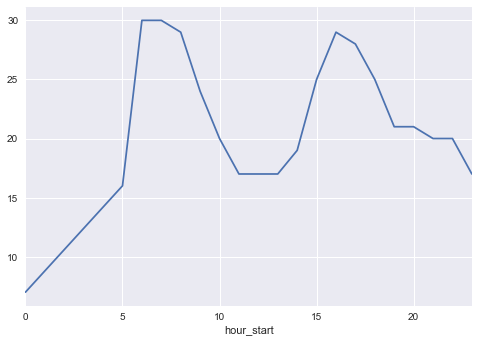

In [27]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

red_line.groupby("hour_start").trip_id.nunique().plot()

Now let's visualize the trip delays.

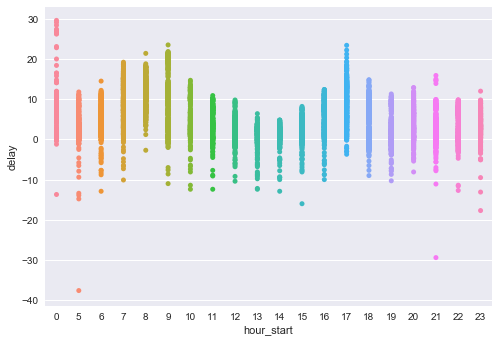

In [28]:
sns.stripplot(x="hour_start", y="delay", data=red_line)

Note that we're collapsing all the stops a trip makes into a line, so we can't distinguish between a train that leaves the first station late from a train that starts on time and gets progressively later the further it gets from its origin.

We can address this in a few ways.

We could take the mean delay of each trip:

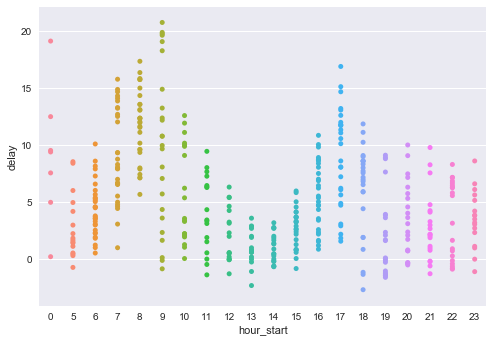

In [29]:
red_line_trips = red_line.groupby("trip_id")
red_line_trip_delays = pd.DataFrame({
    "delay": red_line_trips.delay.mean(), 
    "hour_start": red_line_trips.hour_start.first()})
sns.stripplot(x="hour_start", y="delay", data=red_line_trip_delays)

This gives an overall impression of how early or late entire trips are, but we can do better. We can use a heatmap to show the average lateness at each stop for each hour:

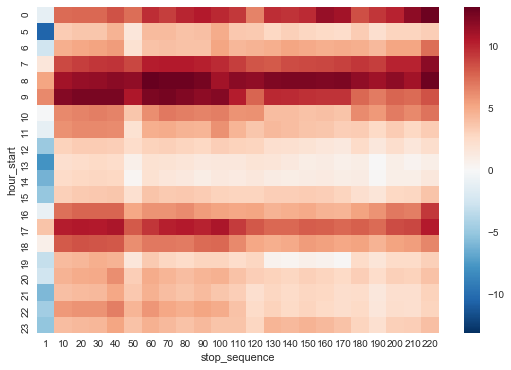

In [52]:
def reshape(stops):
    return stops.groupby("stop_sequence").delay.mean()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(red_line.groupby("hour_start").apply(reshape), 
            ax=ax)

We could also take a closer look at the trips for a particular hour. In particular, let's look at delays plotted against `stop_sequence`.

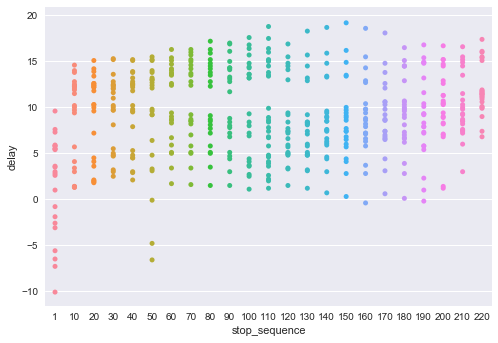

In [30]:
red_line_7 = red_line.query("hour_start == 7")
sns.stripplot(x="stop_sequence", 
              y="delay", 
              data=red_line_7)

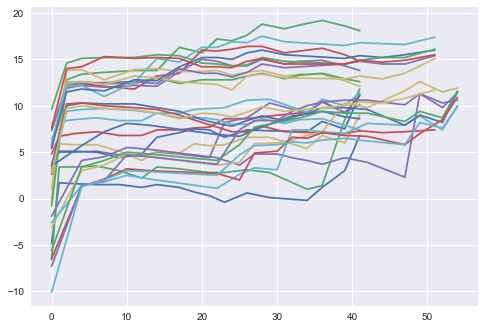

In [69]:
plt.figure(1)

for trip_id, stops in red_line_7.groupby("trip_id"):
    plt.plot(stops.schedule_offset/60, stops.delay, label=trip_id)

plt.show()

In [33]:
red_line_7_stops = red_line_7.groupby("stop_sequence").delay.describe()
red_line_7_stops.head()

,count,mean,std,min,25%,50%,75%,max
stop_sequence,,,,,,,,
1,23.0,1.608696,5.371551,-10.1,-2.25,3.0,5.65,9.6
10,23.0,8.743478,4.775108,1.3,3.75,10.2,12.35,14.6
20,23.0,9.139130,4.596416,1.8,4.30,10.3,12.50,15.1
30,23.0,9.443478,4.010081,2.5,5.25,10.2,12.35,15.3
40,23.0,9.547826,4.260161,2.1,5.05,10.2,12.70,15.2


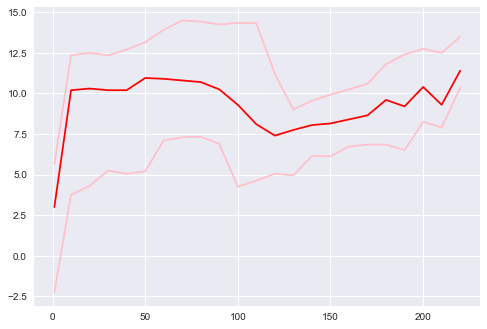

In [37]:
plt.figure(1)
plt.plot(red_line_7_stops["50%"], color="red")
plt.plot(red_line_7_stops["25%"], color="pink")
plt.plot(red_line_7_stops["75%"], color="pink")
plt.show()

This shows us the bounds of the middle 50 of the delays on red line trains starting between 7 and 8 am.

We can show the 

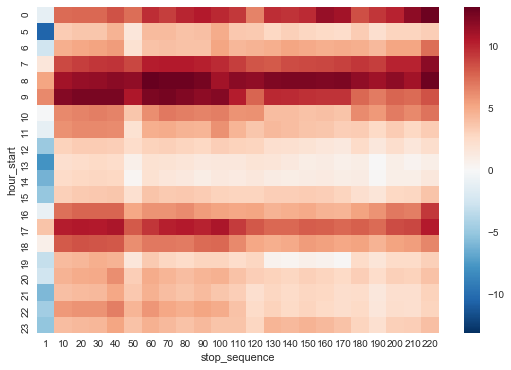

In [51]:
def reshape(stops):
    return stops.groupby("stop_sequence").delay.mean()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(red_line.groupby("hour_start").apply(reshape), 
            ax=ax)

How about some readable stop names?

In [16]:
stop_info = get_manifest_item(manifest, "stops")
stop_info.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding
0,Wareham Village,NaN,Wareham Village,NaN,41.758333,-70.714722,NaN,NaN,0,NaN,1
1,Buzzards Bay,NaN,Buzzards Bay,NaN,41.744805,-70.616226,NaN,NaN,0,NaN,1
2,Hyannis,NaN,Hyannis,NaN,41.660225,-70.276583,NaN,NaN,0,NaN,1
3,Logan-E,NaN,Logan Airport Terminal E,NaN,42.370022,-71.020754,NaN,NaN,0,NaN,1
4,Logan-Subway,NaN,Airport Subway Station,NaN,42.374699,-71.029831,NaN,NaN,0,NaN,1


In [19]:
stops_named = pd.merge(joined, stop_info[["stop_id", "stop_name"]], on=["stop_id"])
stops_named.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,lat,lon,timestamp,arrival_time,route_id,trip_headsign,scheduled_arrival_time,delay,stop_name
0,35291637,2017-09-13,70105,1,545069DD,42.207489,-71.001732,2017-09-13 04:27:00-04:00,05:22:00,Red,Alewife,2017-09-13 05:22:00-04:00,-1 days +23:05:00,Braintree
1,35291639,2017-09-13,70105,1,545075E8,42.207489,-71.001556,2017-09-13 05:18:18-04:00,05:32:00,Red,Alewife,2017-09-13 05:32:00-04:00,-1 days +23:46:18,Braintree
2,35291648,2017-09-13,70105,1,54507692,42.207489,-71.001556,2017-09-13 05:42:32-04:00,05:53:00,Red,Alewife,2017-09-13 05:53:00-04:00,-1 days +23:49:32,Braintree
3,35291804,2017-09-13,70105,1,545069DE,42.207489,-71.001732,2017-09-13 05:46:09-04:00,06:00:00,Red,Alewife,2017-09-13 06:00:00-04:00,-1 days +23:46:09,Braintree
4,35291662,2017-09-13,70105,1,54507694,42.207489,-71.001556,2017-09-13 05:57:14-04:00,06:07:00,Red,Alewife,2017-09-13 06:07:00-04:00,-1 days +23:50:14,Braintree


In [20]:
routes = get_manifest_item(manifest, "routes")

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order


In [33]:
routes[routes.agency_id == 2]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order
1,Logan-22,2,Shuttle,Massport Subway Shuttle (22),Airport Shuttle,3,NaN,NaN,NaN,2000022
2,Logan-33,2,Shuttle,Massport Subway Shuttle (33),Airport Shuttle,3,NaN,NaN,NaN,2000033
3,Logan-55,2,Shuttle,Massport Subway Shuttle (55),Airport Shuttle,3,NaN,NaN,NaN,2000055
4,Logan-66,2,Shuttle,Massport Subway / Ferry Terminal Shuttle (66),Airport Shuttle,3,NaN,NaN,NaN,2000066


In [62]:
# 
# recent_updates.head()
# trips
# recent_updates.trip_id = recent_updates.trip_id.str.strip()
# pd.merge(recent_updates, trips, on="trip_id")
recent_updates = get_updates(datetime.now() - timedelta(days=1))
recent_updates = pd.merge(recent_updates, trips, on="trip_id")

In [71]:
recent_updates.route_id.nunique()

194

In [80]:
grouped_routes = recent_updates.groupby("route_id")
distinct_trips = grouped_routes.trip_id.nunique()
distinct_updates = grouped_routes.count().trip_id

In [88]:
route_stats = pd.concat({"trips": distinct_trips, "updates": distinct_updates}, axis=1)
route_stats["updates per trip"] = route_stats["updates"]/route_stats["trips"]
route_stats.sort_values("updates", ascending=False)

,trips,updates,updates per trip
route_id,,,
Red,428,24317,56.815421
Orange,294,14930,50.782313
66,205,13542,66.058537
28,222,12295,55.382883
23,236,12133,51.411017
1,221,11495,52.013575
39,251,11441,45.581673
77,305,10619,34.816393
Blue,371,10525,28.369272
